# Grayscale Image Segmentation And Validation

In [1]:
import cv2
import matplotlib.pyplot as plt
import nose.tools
import numpy as np
import scipy.misc
import scipy.ndimage
import skimage.filters
import sklearn.metrics
# Optional, added to ignore scipy read warnings
import warnings; warnings.simplefilter('ignore')

# Optional, to see the plots immediately without having to do plt.show() after every plt.imshow()
plt.ion()

# LOADING AND VISUALIZING DATA

(-0.5, 511.5, 511.5, -0.5)

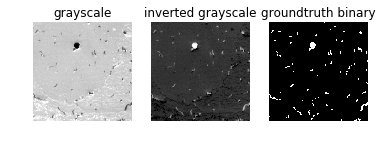

In [2]:
grayscale = scipy.misc.imread("grayscale.png")
grayscale = 255 - grayscale
groundtruth = scipy.misc.imread("groundtruth.png")

plt.subplot(1, 3, 1)
plt.imshow(255 - grayscale, cmap='gray')
plt.title("grayscale")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(grayscale, cmap='gray')
plt.title("inverted grayscale")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(groundtruth, cmap='gray')
plt.title("groundtruth binary")
plt.axis("off")

# PRE-PROCESSING

Text(0.5, 1.0, 'median filtered image')

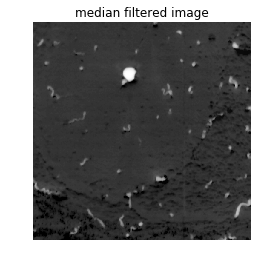

In [3]:
median_filtered = scipy.ndimage.median_filter(grayscale, size=3)
plt.imshow(median_filtered, cmap='gray')
plt.axis('off')
plt.title("median filtered image")

IMAGE PIXEL INTENSITY HISTOGRAM

Text(0, 0.5, 'Count')

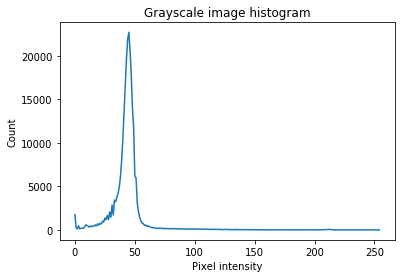

In [4]:
counts, vals = np.histogram(grayscale, bins=range(2 ** 8))

plt.plot(range(0, (2 ** 8) - 1), counts)
plt.title("Grayscale image histogram")
plt.xlabel("Pixel intensity")
plt.ylabel("Count")

# SEGMENTATION/THRESHOLDING USING SKIMAGE 

skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu


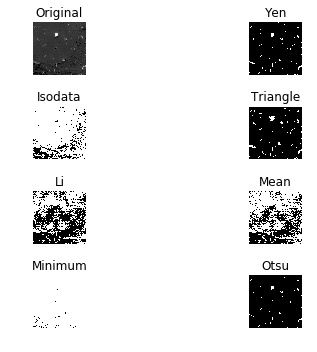

In [5]:
result = skimage.filters.thresholding.try_all_threshold(median_filtered)

1. Otsu threshold - The algorithm assumes that the image contains two classes of pixels following bi-modal histogram (foreground pixels and background pixels), it then calculates the optimum threshold separating the two classes so that their combined spread (intra-class variance) is minimal, or equivalently (because the sum of pairwise squared distances is constant), so that their inter-class variance is maximal

Threshold value is 79


Text(0.5, 1.0, 'otsu predicted binary image')

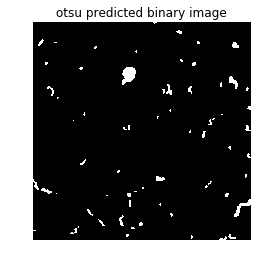

In [6]:
threshold = skimage.filters.threshold_otsu(median_filtered)
print("Threshold value is {}".format(threshold))
predicted = np.uint8(median_filtered > threshold) * 255
plt.imshow(predicted, cmap='gray')
plt.axis('off')
plt.title("otsu predicted binary image")

# VALIDATION METRICS

Takeaway - Matthew Correlation Coefficient -https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html

In [7]:
def _assert_valid_lists(groundtruth_list, predicted_list):
    assert len(groundtruth_list) == len(predicted_list)
    for unique_element in np.unique(groundtruth_list).tolist():
        assert unique_element in [0, 1]


def _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [1]


def _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [0]


def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """
    Return confusion matrix elements covering edge cases

    :param groundtruth_list list of groundtruth elements
    :param predicted_list list of predicted elements
    :return returns confusion matrix elements i.e TN, FP, FN, TP in that order and as floats
    returned as floats to make it feasible for float division for further calculations on them
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    
    if _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(groundtruth_list))

    elif _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = np.float64(len(groundtruth_list)), 0, 0, 0
    
    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
        tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp


def _all_class_0_predicted_as_class_1(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == [0] and np.unique(predicted_list).tolist() == [1]


def _all_class_1_predicted_as_class_0(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == [1] and np.unique(predicted_list).tolist() == [0]


def _mcc_denominator_zero(tn, fp, fn, tp):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return (tn == 0 and fn == 0) or (tn == 0 and fp == 0) or (tp == 0 and fp == 0) or (tp == 0 and fn == 0)


def get_f1_score(groundtruth_list, predicted_list):
    """
    Return f1 score covering edge cases

    :param groundtruth_list list of groundtruth elements
    :param predicted_list list of predicted elements
    :return returns f1 score
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        f1_score = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        f1_score = 1
    else:
        f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_mcc(groundtruth_list, predicted_list):
    """
    Return mcc covering edge cases

    :param groundtruth_list list of groundtruth elements
    :param predicted_list list of predicted elements
    :return returns mcc
    """   
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        mcc = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        mcc = 1
    elif _all_class_1_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        mcc = -1
    elif _all_class_0_predicted_as_class_1(groundtruth_list, predicted_list) is True :
        mcc = -1
    elif _mcc_denominator_zero(tn, fp, fn, tp) is True:
        mcc = -1
    else:
        mcc = ((tp * tn) - (fp * fn)) / (
            np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    
    return mcc


def get_accuracy(groundtruth_list, predicted_list):
    """
    Return accuracy

    :param groundtruth_list list of elements
    :param predicted_list list of elements
    :return returns accuracy
    """  
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    
    return accuracy


def get_validation_metrics(groundtruth_list, predicted_list):
    """
    Return validation metrics dictionary with accuracy, f1 score, mcc after
    comparing ground truth and predicted image

    :param groundtruth_list list of elements
    :param predicted_list list of elements
    :return returns a dictionary with accuracy, f1 score, and mcc as keys
    one could add other stats like FPR, FNR, TP, TN, FP, FN etc
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    validation_metrics = {}
    
    validation_metrics["accuracy"] = get_accuracy(groundtruth_list, predicted_list)
    validation_metrics["f1_score"] = get_f1_score(groundtruth_list, predicted_list)
    validation_metrics["mcc"] = get_mcc(groundtruth_list, predicted_list)
    
    return validation_metrics


In [8]:
number_foreground_pixels = np.sum(groundtruth == 255)
number_background_pixels = np.sum(groundtruth == 0)

print("Number of foreground(255) pixels are {}".format(number_foreground_pixels))
print("Number of background(0) pixels are {}".format(number_background_pixels))

Number of foreground(255) pixels are 7458
Number of background(0) pixels are 254686


In [9]:
groundtruth_scaled = groundtruth // 255
predicted_scaled = predicted // 255

groundtruth_list = (groundtruth_scaled).flatten().tolist()
predicted_list = (predicted_scaled).flatten().tolist()
validation_metrics = get_validation_metrics(groundtruth_list, predicted_list)
print("Validation Metrics comparing Otsu and ground truth")
print(validation_metrics)

Validation Metrics comparing Otsu and ground truth
{'f1_score': 0.8493358633776091, 'mcc': 0.8533910225863214, 'accuracy': 0.9924278259277344}


# VALIDATION VISUALIZATION

In [10]:
# Confusion matrix overlay masks where TP, FP, FN, TN columns in the masks are in different colors

def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    """
    Returns a dictionary of 4 boolean numpy arrays containing True at TP, FP, FN, TN.
    """
    confusion_matrix_arrs = {}

    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs["tp"] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs["tn"] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs["fp"] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs["fn"] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs


def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, alpha, colors):
    """
    Returns overlay the 'image' with a color mask where TP, FP, FN, TN are
    each a color given by the 'colors' dictionary
    """
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)

    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb

    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)

Cyan - TP
Magenta - FP
Yellow - FN
Black - TN


Text(0.5, 1.0, 'confusion matrix overlay mask')

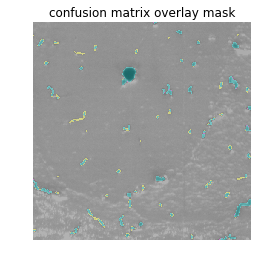

In [11]:
alpha = 0.7
confusion_matrix_colors = {
   "tp": (0, 255, 255),  #cyan
   "fp": (255, 0, 255),  #magenta
   "fn": (255, 255, 0),  #yellow
   "tn": (0, 0, 0)     #black
   }

validation_mask = get_confusion_matrix_overlaid_mask(255 - grayscale, groundtruth, predicted, alpha, confusion_matrix_colors)
print("Cyan - TP")
print("Magenta - FP")
print("Yellow - FN")
print("Black - TN")

plt.imshow(validation_mask)
plt.axis('off')
plt.title("confusion matrix overlay mask")

In [12]:
ZEROS = [0, 0, 0, 0, 0, 0, 0, 0, 0]
ONES = [1, 1, 1, 1, 1, 1, 1, 1, 1]
ORIGINAL = [1, 0, 1, 0, 1, 1, 0, 0, 0]
PREDICTED = [1, 0, 1, 0, 0, 1, 1, 0, 0]
ORIGINAL_ARRAY = np.array(ORIGINAL).reshape(3, 3).astype(np.uint8)
PREDICTED_ARRAY = np.array(PREDICTED).reshape(3, 3).astype(np.uint8)

In [13]:
def test_get_validation_metrics():
    validation_metrics = get_validation_metrics(ZEROS, ONES)
    nose.tools.assert_equal(validation_metrics["f1_score"], 0)
    nose.tools.assert_equal(validation_metrics["mcc"], -1)

    validation_metrics = get_validation_metrics(ONES, ONES)
    nose.tools.assert_equal(validation_metrics["f1_score"], 1)
    nose.tools.assert_equal(validation_metrics["mcc"], 1)
    
    validation_metrics = get_validation_metrics(ZEROS, ZEROS)
    nose.tools.assert_equal(validation_metrics["f1_score"], 1)
    nose.tools.assert_equal(validation_metrics["mcc"], 1)
    
    validation_metrics = get_validation_metrics(ONES, ZEROS)
    nose.tools.assert_equal(validation_metrics["f1_score"], 0)
    nose.tools.assert_equal(validation_metrics["mcc"], -1)
    
    validation_metrics = get_validation_metrics(ORIGINAL, ORIGINAL)
    nose.tools.assert_equal(validation_metrics["f1_score"], 1)
    nose.tools.assert_equal(validation_metrics["accuracy"], 1)
    nose.tools.assert_equal(validation_metrics["mcc"], 1)
    
    validation_metrics = get_validation_metrics(ORIGINAL, PREDICTED)
    nose.tools.assert_almost_equal(validation_metrics["f1_score"], 0.75, places=3)


test_get_validation_metrics()

In [14]:
def test_get_confusion_matrix_intersection_mats():
    confusion_matrix_mats = get_confusion_matrix_intersection_mats(ORIGINAL, PREDICTED)
    nose.tools.assert_equal(confusion_matrix_mats["tp"].sum(), 3.0)
    nose.tools.assert_equal(confusion_matrix_mats["fp"].sum(), 1.0)
    nose.tools.assert_equal(confusion_matrix_mats["fn"].sum(), 1.0)
    nose.tools.assert_equal(confusion_matrix_mats["tn"].sum(), 4.0)

test_get_confusion_matrix_intersection_mats()

In [15]:
def test_get_confusion_matrix_overlaid_mask():
    confusion_matrix_mask = get_confusion_matrix_overlaid_mask(
        ORIGINAL_ARRAY, ORIGINAL_ARRAY, PREDICTED_ARRAY, 0.5, confusion_matrix_colors)
    expected = [0, 128, 128, 0, 0, 0, 0, 128, 128, 0, 0, 0, 128, 128, 0, 0, 128, 128, 128, 0, 128, 0, 0, 0, 0, 0, 0]
    np.testing.assert_array_equal(confusion_matrix_mask.flatten().tolist(), expected)

    
test_get_confusion_matrix_overlaid_mask()